In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_csv("electricity_cost_dataset.csv")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   site area             10000 non-null  int64  
 1   structure type        10000 non-null  object 
 2   water consumption     10000 non-null  float64
 3   recycling rate        10000 non-null  int64  
 4   utilisation rate      10000 non-null  int64  
 5   air qality index      10000 non-null  int64  
 6   issue reolution time  10000 non-null  int64  
 7   resident count        10000 non-null  int64  
 8   electricity cost      10000 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 703.3+ KB
None


In [4]:
# Data gak ada missing value
df.describe()

,site area,water consumption,recycling rate,utilisation rate,air qality index,issue reolution time,resident count,electricity cost
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2757.775100,3494.057100,49.598000,64.842200,99.468600,36.402600,85.573100,2837.845000
std,1293.059959,2076.181117,23.430141,20.432965,58.014526,20.623905,107.876179,1106.997441
min,501.000000,1000.000000,10.000000,30.000000,0.000000,1.000000,0.000000,500.000000
25%,1624.000000,1779.000000,29.750000,47.000000,49.000000,19.000000,0.000000,1954.000000
50%,2773.500000,3047.500000,49.000000,65.000000,100.000000,36.000000,39.000000,2760.000000
75%,3874.000000,4811.000000,70.000000,83.000000,150.000000,54.000000,142.000000,3632.000000
max,5000.000000,10894.000000,90.000000,100.000000,200.000000,72.000000,489.000000,6446.000000


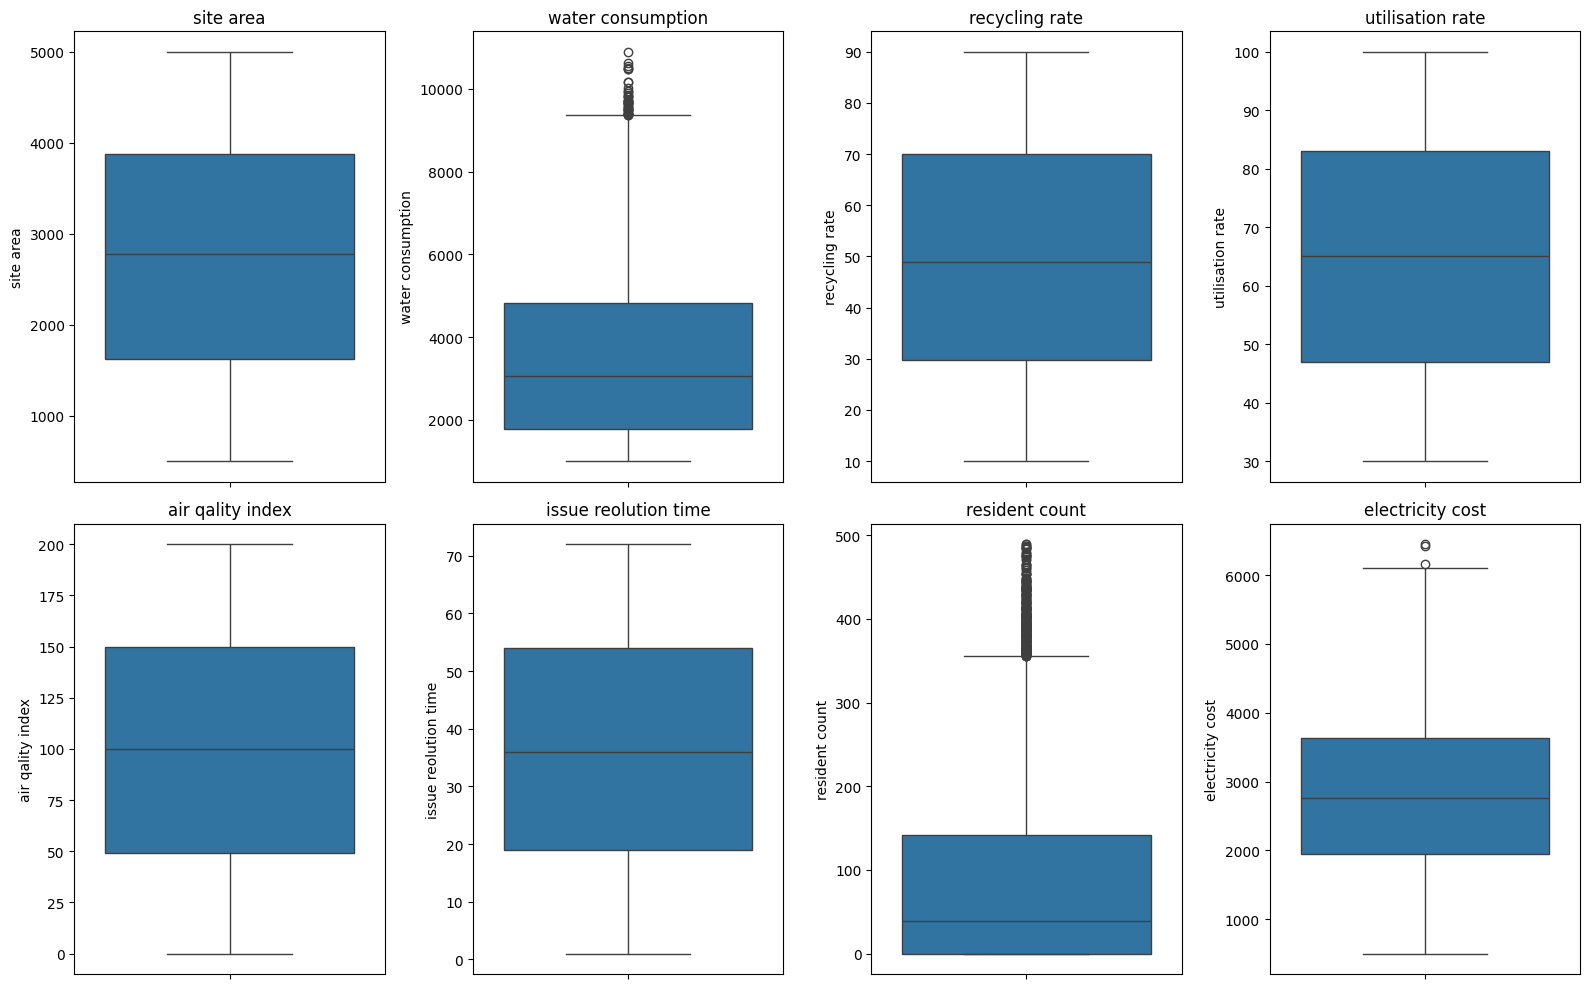

In [5]:
# cek outlier dengan boxplot

import matplotlib.pyplot as plt
import seaborn as sns

# Ambil hanya kolom numerik
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Buat subplot untuk setiap fitur numerik
plt.figure(figsize=(16, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)  # 2 baris, 4 kolom (karena ada 8 fitur numerik)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [ ]:
# Keputusan : Scaling dengan Standard Scaler, Label Encoding, Outlier biarkan
# Model : Linreg, DesReg, SVR, LassoRidge, PolynomialReg, 


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


# ====== 2. Tentukan fitur & target ======
X = df.drop(columns=["electricity cost"])   # fitur
y = df["electricity cost"]                 # target

# ====== 3. Pisahkan kolom numerik & kategorikal ======
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = ["structure type"]

# ====== 4. Transformer Handling Outlier (contoh: log untuk 2 kolom) ======
def log_transform(X):
    X = X.copy()
    for col in ["water consumption", "resident count"]:
        if col in X.columns:
            X[col] = np.log1p(X[col])  # log(1+x) untuk aman
    return X

outlier_transformer = FunctionTransformer(log_transform)

# ====== 5. Preprocessor: scaling + encoding ======
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

# ====== 6. Pipeline Builder ======
def build_pipeline(model, poly_degree=None):
    steps = []
    # steps.append(("outlier", outlier_transformer)) # Gak jadi pakai outlier karena r2 turun kalau di log transform
    steps.append(("preprocessor", preprocessor))
    if poly_degree:  # hanya kalau polynomial
        steps.append(("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)))
        steps.append(("scaler_poly", StandardScaler()))  # scale lagi setelah poly
    steps.append(("model", model))
    return Pipeline(steps)

# ====== 7. Model Candidates ======
models = {
    "Linear Regression": build_pipeline(LinearRegression()),
    "Decision Tree": build_pipeline(DecisionTreeRegressor(random_state=42)),
    "SVR": build_pipeline(SVR(kernel="rbf", C=300, gamma=0.1, epsilon=0.1)),
    "Lasso": build_pipeline(Lasso(alpha=0.1, random_state=42)),
    "Ridge": build_pipeline(Ridge(alpha=1.0, random_state=42)),
    "Polynomial Regression (deg=2)": build_pipeline(LinearRegression(), poly_degree=2)
}

# ====== 8. Train-Test Split ======
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ====== 9. Evaluasi Cepat ======
from sklearn.metrics import r2_score, mean_squared_error

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: R2={r2:.3f}, RMSE={rmse:.2f}")





Linear Regression: R2=0.917, RMSE=321.17
Decision Tree: R2=0.921, RMSE=313.90
SVR: R2=0.956, RMSE=233.28
Lasso: R2=0.917, RMSE=321.14
Ridge: R2=0.917, RMSE=321.14
Polynomial Regression (deg=2): R2=0.963, RMSE=213.76
